# Preparacion de datos

Este JupyterLab documenta el proceso de preparación y análisis de un conjunto de datos que contiene información sobre las transacciones registradas por la herramienta de transferencia de archivos GoAnywhere. El objetivo principal es realizar procesos de limpieza, estandarización, selección y adecuación de variables.

El conjunto de datos fue previamente sometido a un proceso de anonimización, con el fin de proteger información sensible como usuarios de conexión, direcciones IP/DNS de los servidores, rutas de archivo, áreas de negocio implicadas y acciones específicas sobre los archivos (como compresión/descompresión y encriptación/desencriptación).

Las principales actividades realizadas ente documento incluyen:

- Importación y estandarización de datos para validar coherencia y calidad en los registros.
- Agrupación de datos por ventanas de tiempo de 5 minutos.
- Visualizaciones de los datos para tener visión general del comportamiento de las transmisiones.

## 1. Importación de Librerias y declaración de funciones

### 1.1 Importación de librerias

In [122]:
## Importación Librerias
# ==============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#path carga de set de datos anonimizado
# ==============================================================================
path='./01_data_initial.csv'

### 1.2 Declaración funciones

In [120]:
#Funcion para realizar graficos de barra generico
def gf_barras(dataframe, columna,titulo,xlabel,ylabel):
    # Configurar el estilo de Seaborn (opcional)
    sns.set(style="whitegrid")
    
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico (ancho, alto)
    ax = sns.countplot(data=dataframe, x=columna, palette="viridis")
    
    # 2. Calcular total y porcentajes
    total = len(data)
    percentages = []
    for p in ax.patches:
        count = p.get_height()
        percentages.append(100 * count / total)
    
    # 3. Añadir etiquetas duales (conteo + %)
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.5,
                f'{height}\n({percentages[i]:.1f}%)',  # \n para salto de línea
                ha='center', va='bottom', fontsize=10, color='black')
    
    # 4. Personalización
    plt.title(titulo)  # Título
    plt.xlabel(xlabel) # Etiqueta eje X
    plt.ylabel(ylabel) # Etiqueta eje Y
    #plt.xticks(rotation=45)
    sns.despine(left=True)  # Quitar borde izquierdo para mejor visualización
    plt.tight_layout()
    plt.show()

In [123]:
#Funcion para realizar graficos de torta generico
def gf_torta(datos_filtrados, columna,titulo):

    # Filtrar los datos
    #datos_filtrados = data[data['type_transmission'] == 'recoleccion']
    
    # Contar la frecuencia de cada código de error
    conteo_errores = datos_filtrados[columna].value_counts()
    
    # Configurar el gráfico de pastel
    plt.figure(figsize=(10, 8))
    
    # Crear el gráfico con autopct para % y función personalizada para mostrar cantidad
    def formato_pastel(pct, valores):
        cantidad = int(round(pct/100.*sum(valores)))
        return f"{cantidad}\n({pct:.1f}%)"
    
    conteo_errores.plot(
        kind='pie',
        autopct=lambda pct: formato_pastel(pct, conteo_errores),
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 10}
    )
    
    # Añadir título y ajustar layout
    plt.title(titulo, pad=20)
    plt.ylabel("") 
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

In [124]:
#Funcion para realizar graficos de barra en escala logaritmica generica
def gf_barras_log(dataframe, columna, X, Y):
        
    # 1. Crear bins logarítmicos y agrupar los datos
    log_bins = [10**i for i in range(0, int(np.log10(dataframe[columna].max())) + 2)]
    dataframe[f'{columna}_grouped'] = pd.cut(dataframe[columna], bins=log_bins, include_lowest=True)
    
    # 3. Configurar el gráfico
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=dataframe, x=f'{columna}_grouped', palette='rocket')
    
    # 4. Añadir etiquetas duales (conteo + %)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height}',  # Texto a mostrar (el conteo)
            (p.get_x() + p.get_width() / 2., height),  # Posición (centro de la barra)
            ha='center', va='center',  # Alineación horizontal/vertical
            xytext=(0, 5),  # Desplazamiento vertical del texto
            textcoords='offset points'  # Sistema de coordenadas
        )
    
    # 5. Personalización adicional
    plt.title(f'Distribución logarítmica: {columna}')
    plt.xlabel(X)
    plt.ylabel(Y)
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    dataframe.drop(columns=[f'{columna}_grouped'], inplace=True)

## 2. Carga y limpieza de los datos

- Se realiza la importación del conjunto de datos almacenado en el archivo "01_data_initial.csv". Es importante tener en cuenta que esta información será asignada a la variable "data", el cual corresponde a un objeto de tipo DataFrame de la biblioteca pandas, la cual permitirá su manipulación y análisis.

In [125]:
#Carga inicial de los datos
data = pd.read_csv(f"{path}")
type(data)

pandas.core.frame.DataFrame

In [126]:
#Vista de los 3 primeros registros del dataframe
data.head(3)

,type_transmission,date_start_transmission,date_end_transmission,error_code,num_files,files_size
0,a_demanda,2025-04-07 00:59:22.759,2025-04-07 00:59:22.776,OK,1,584
1,a_demanda,2025-04-07 00:59:22.876,2025-04-07 00:59:22.891,OK,1,584
2,a_demanda,2025-04-07 00:59:22.759,2025-04-07 00:59:22.776,OK,1,584


In [127]:
# Información de las columnas del datafreme
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654684 entries, 0 to 1654683
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   type_transmission        1654684 non-null  object
 1   date_start_transmission  1654684 non-null  object
 2   date_end_transmission    1654684 non-null  object
 3   error_code               1654684 non-null  object
 4   num_files                1654684 non-null  int64 
 5   files_size               1654684 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 75.7+ MB


In [128]:
# Cantidad de valores unicos de la columna "type_transmission"
data['type_transmission'].value_counts()

type_transmission
recoleccion    1368741
a_demanda       285943
Name: count, dtype: int64

In [129]:
# Cantidad de valores unicos de la columna "error_code"
data['error_code'].value_counts()

error_code
PEN    946932
OK     664843
NOK     42909
Name: count, dtype: int64

In [130]:
# Cantidad de valores unicos de la columna "num_files"
data['num_files'].value_counts()

num_files
0       962945
1       594308
2        21988
3        11632
5         8438
         ...  
584          1
358          1
1426         1
1828         1
1770         1
Name: count, Length: 1414, dtype: int64

In [131]:
data['num_files'].max()

np.int64(41171)

In [132]:
# Cantidad de valores unicos de la columna "files_size"
data['files_size'].value_counts()

files_size
0           993400
10            4907
359           4877
383776        3776
505           3766
             ...  
78050508         1
49466236         1
27359827         1
10593564         1
125112           1
Name: count, Length: 148169, dtype: int64

In [133]:
data['files_size'].max()

np.int64(56116692484)

### Resumen de la sesión: Carga del conjunto de datos
En esta sesión se realizó la carga inicial del archivo "01_data_initial.csv", junto con una visualización preliminar del contenido y un resumen general del DataFrame.

A partir de la ejecución del método data.info(), se identificaron los siguientes aspectos clave:

- El conjunto de datos contiene 6 columnas relacionadas con las transacciones de transferencia de archivos.
- Las columnas "num_files" y "files_size" son de tipo "int64", lo cual es adecuado, ya que representan la cantidad de archivos transferidos y el tamaño de los archivos en bytes, respectivamente.
- La columna "files_size" representa el tamaño de archivos en bytes, lo que no facilita su comprensión, más adelante se realizará un escalado para que los valores queden en MB y sea más facil su interpretación.
- Las columnas "date_start_transmission" y "date_end_transmission" aparecen como tipo "object", lo cual indica un tipo de dato incorrecto. Estas columnas representan marcas de tiempo, por lo que deberán ser convertidas al tipo datetime.
- Existen solo dos valores en la columna "type_transmission", los cuales son: "recoleccion" y "a_demanda", esto indica que en la actualidad hay 2 modelos de transmision de archivos habilitados en la herramienta MFT.
- Existen solo tres valores en la columna "error_code", los cuales son:
    * "OK":  Ejecucion exitosa
    * "NOK": Ejecucion fallida
    * "PEN": Ejecucion sin archivos en el origen
- Para las columnas "num_files" y "files_size", se tiene gran cantidad de valores unicos, pero se puede interpretar al alto nivel que:
    * para "num_files": La mayor cantidad de archivos transmitidos en una transmision a sido de 41.171 archivos
    * para "files_size": El tamaño de archivos más grande transmitido es de 56116692484 bytes, lo que equivale a 56.11 GB

### 2.1 Modificación del tipo y escala de los datos

#### 2.1.1 Cambio Dtype columnas date
Como se identificó en la sesión anterior, es necesario modificar el tipo de dato de las columnas "date_start_transmission" y "date_end_transmission", ya que representan marcas de tiempo (fechas y horas) y actualmente están tipadas como "object", este cambio permitirá hacer operación sobre estas columnas.

In [134]:
# Cambiar tipo de datos de la columna date_start_transmission
data['date_start_transmission'] = pd.to_datetime(data['date_start_transmission'], format='%Y-%m-%d %H:%M:%S.%f')

In [135]:
# Cambiar tipo de datos de la columna date_end_transmission
data['date_end_transmission'] = pd.to_datetime(data['date_end_transmission'], format='%Y-%m-%d %H:%M:%S.%f')

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654684 entries, 0 to 1654683
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   type_transmission        1654684 non-null  object        
 1   date_start_transmission  1654684 non-null  datetime64[ns]
 2   date_end_transmission    1654684 non-null  datetime64[ns]
 3   error_code               1654684 non-null  object        
 4   num_files                1654684 non-null  int64         
 5   files_size               1654684 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 75.7+ MB


#### 2.1.2 Cambio escala tamaño de archivos de bytes to MB
En la sesion anterior se percató que la manipulacion de bytes para el tamaño de archivos es poco practico, por ende se cambiara a unidades de MB los valores de la columna "files_size"

In [137]:
data['files_size_MB'] = data['files_size'] / (1024 * 1024)  # 1 MB = 1,048,576 bytes
data.drop(columns=['files_size'], inplace=True)

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654684 entries, 0 to 1654683
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   type_transmission        1654684 non-null  object        
 1   date_start_transmission  1654684 non-null  datetime64[ns]
 2   date_end_transmission    1654684 non-null  datetime64[ns]
 3   error_code               1654684 non-null  object        
 4   num_files                1654684 non-null  int64         
 5   files_size_MB            1654684 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 75.7+ MB


### 2.2 Generación nuevas columnas de datos

#### 2.2.1 Creacion columna "duration_transmission"

Dado que se cuenta con la marca de tiempo en el cual inicia la transferencia de archivos ("date_start_transmission") y cuando finaliza ("date_end_transmission"), puede que sea importante para el negocio el comprender como esta la duración de sus transmsiones. 
pdta: esta columna será informativa, solo para comprender un poco la tendencia de duración de las transmisiones y sus valores extremos, pero para identificar anomalias en el sistema no suma revelancia dado que el objetivo es determinar cuando la platafomra probablemente NO este habilitada para transmitir, independiente de la duracion que se tome la transmision.

In [139]:
# Se calcula la duracion de las transmisiones
data['duration_transmission'] = data['date_end_transmission'] - data['date_start_transmission']

In [144]:
# Las 10 transmisiones más rapidas
top_10_menos = data[data['error_code'] == 'OK'].nsmallest(10, 'duration_transmission')
print("Las 10 transferencias más rápidas (error_code = OK):")
print(top_10_menos[['type_transmission', 'duration_transmission','num_files','files_size_MB']])  # Mostrar columnas relevantes

Las 10 transferencias más rápidas (error_code = OK):
       type_transmission  duration_transmission  num_files  files_size_MB
397776         a_demanda 0 days 00:00:00.009000          1       0.000484
801707         a_demanda 0 days 00:00:00.009000          1       0.000502
801711         a_demanda 0 days 00:00:00.009000          1       0.000502
3526           a_demanda 0 days 00:00:00.010000          1       0.000474
3527           a_demanda 0 days 00:00:00.010000          1       0.000474
3881           a_demanda 0 days 00:00:00.010000          1       0.000474
4027           a_demanda 0 days 00:00:00.010000          1       0.000484
7025           a_demanda 0 days 00:00:00.010000          1       0.000474
7026           a_demanda 0 days 00:00:00.010000          1       0.000474
23545          a_demanda 0 days 00:00:00.010000          1       0.000489


In [145]:
# Las 10 transmisiones más demoradas
top_10_mas = data[data['error_code'] == 'OK'].nlargest(10, 'duration_transmission')
print("Las 10 transferencias más demorados (error_code = OK):")
print(top_10_mas[['type_transmission','duration_transmission','num_files','files_size_MB']])  # Mostrar columnas relevantes

Las 10 transferencias más demorados (error_code = OK):
       type_transmission  duration_transmission  num_files  files_size_MB
5011         recoleccion 0 days 22:50:07.487000      41171      12.149324
194865       recoleccion 0 days 22:01:42.934000      41171      12.149324
449614       recoleccion 0 days 21:17:11.876000      41170      12.149023
106059       recoleccion 0 days 20:22:51.926000      41171      12.149324
148937       recoleccion 0 days 20:13:09.010000      41171      12.149324
673636         a_demanda 0 days 19:46:37.780000          1   17890.455233
352141       recoleccion 0 days 19:30:02.077000      41171      12.149324
184934         a_demanda 0 days 18:45:59.777000          1   12637.589753
139953         a_demanda 0 days 18:43:15.976000          1   12733.409995
232722       recoleccion 0 days 18:20:00.676000      41171      12.149324


### 2.3 Identificar y completar valores nulos

In [146]:
# realizar la sumatoria de valores nulos por columna
data.isnull().sum()

type_transmission          0
date_start_transmission    0
date_end_transmission      0
error_code                 0
num_files                  0
files_size_MB              0
duration_transmission      0
dtype: int64

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654684 entries, 0 to 1654683
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype          
---  ------                   --------------    -----          
 0   type_transmission        1654684 non-null  object         
 1   date_start_transmission  1654684 non-null  datetime64[ns] 
 2   date_end_transmission    1654684 non-null  datetime64[ns] 
 3   error_code               1654684 non-null  object         
 4   num_files                1654684 non-null  int64          
 5   files_size_MB            1654684 non-null  float64        
 6   duration_transmission    1654684 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2), timedelta64[ns](1)
memory usage: 88.4+ MB


Nota: Dado que no se presentan valores nulos, por el tipo de negocio/naturaleza de la información no es necesario realizar algun tipo de analisis adicional

## 3. Primeras visualizaciones de los datos 

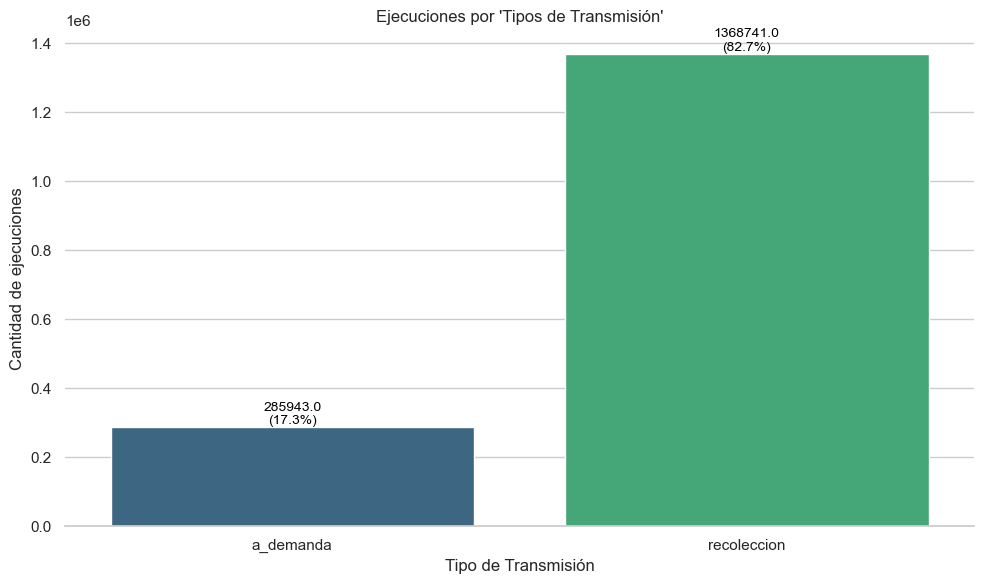

In [148]:
# Grafica de barra de las ejecuciones por tipo de transmision
gf_barras(data,"type_transmission","Ejecuciones por 'Tipos de Transmisión'","Tipo de Transmisión","Cantidad de ejecuciones")

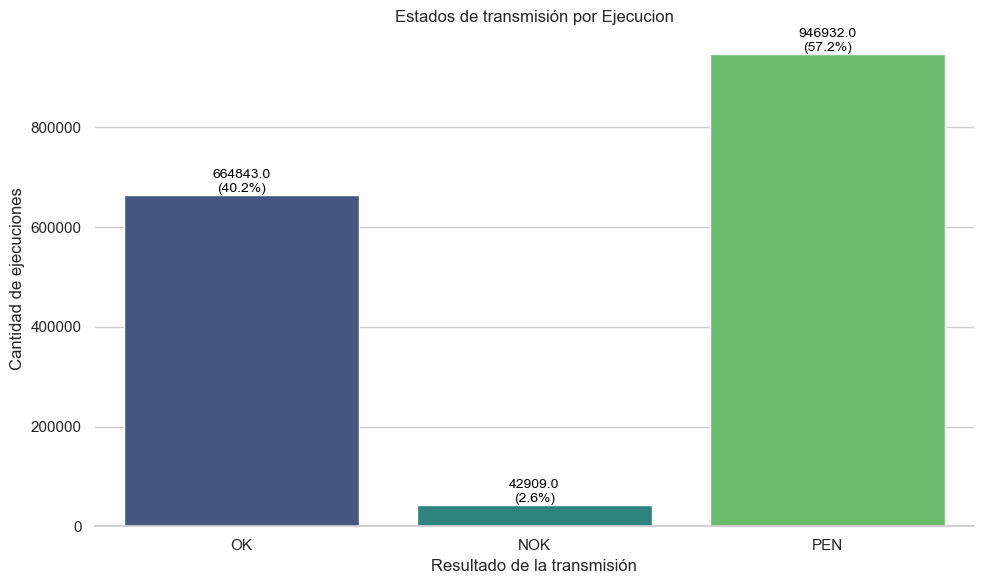

In [149]:
# Grafica de barra de las ejecuciones por tipo de transmision
gf_barras(data,"error_code","Estados de transmisión por Ejecucion","Resultado de la transmisión","Cantidad de ejecuciones")

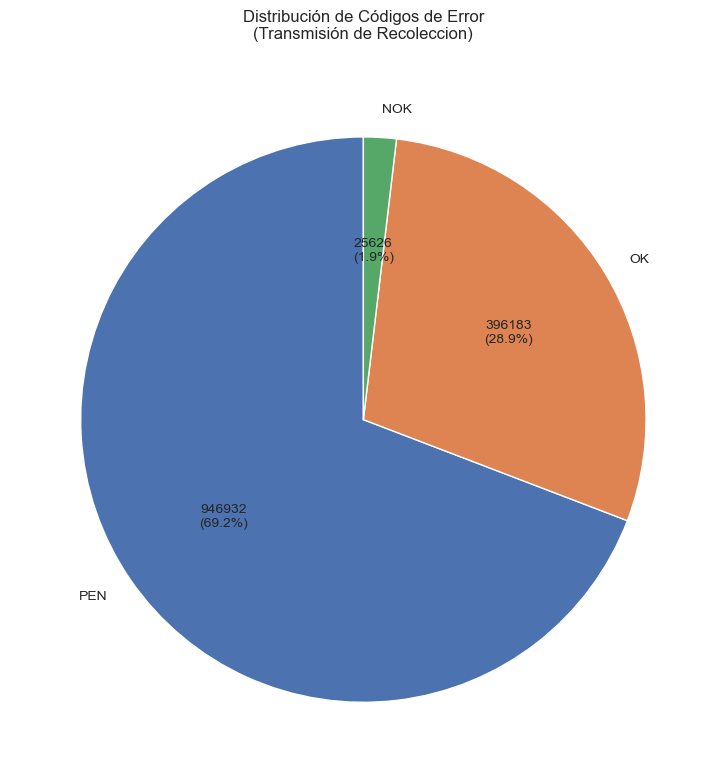

In [150]:
# Grafica de torta del tipo de estado resultante de las transmisiones de recoleccion
gf_torta(data[data['type_transmission'] == 'recoleccion'], 'error_code','Distribución de Códigos de Error\n(Transmisión de Recoleccion)')

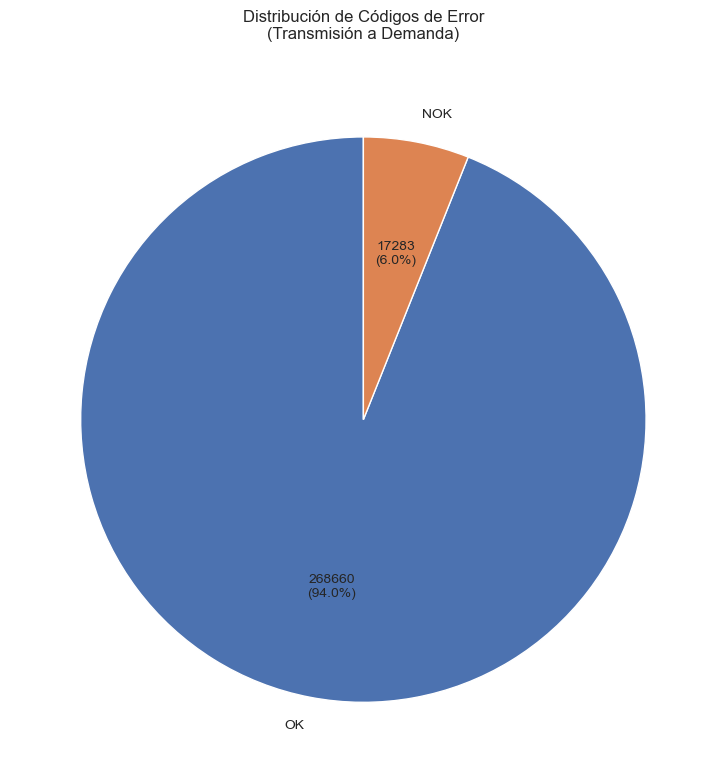

In [151]:
# Grafica de torta del tipo de estado resultante de las transmisiones de a_demanda
gf_torta(data[data['type_transmission'] == 'a_demanda'], 'error_code','Distribución de Códigos de Error\n(Transmisión a Demanda)')

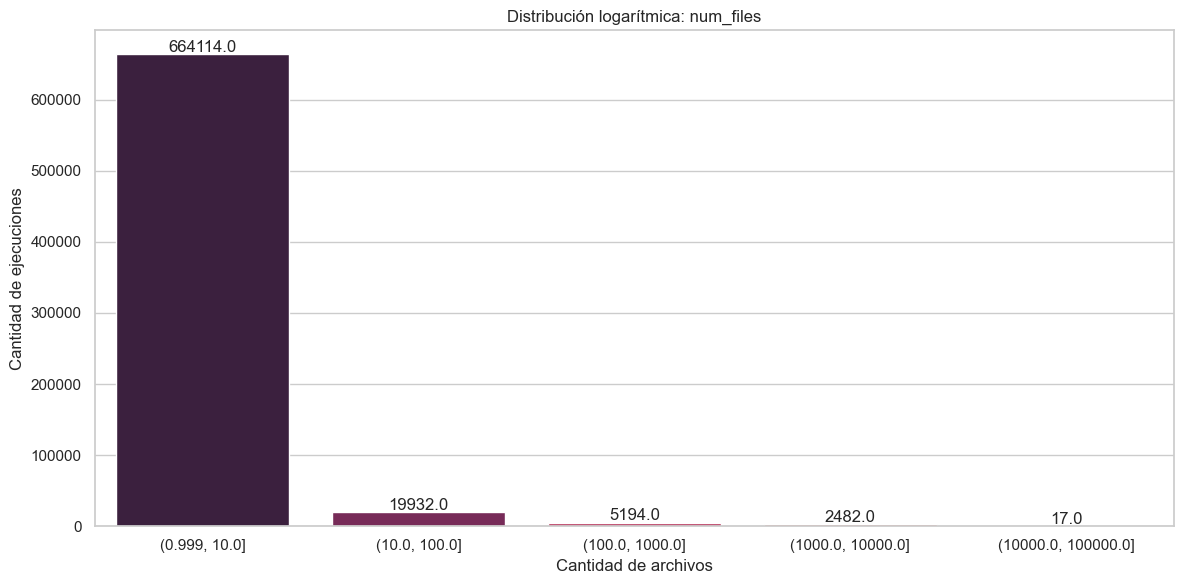

In [152]:
# Grafica de barras en escala logaritmica de cantidad de archivos transmitidos
gf_barras_log(data, 'num_files', 'Cantidad de archivos', 'Cantidad de ejecuciones')

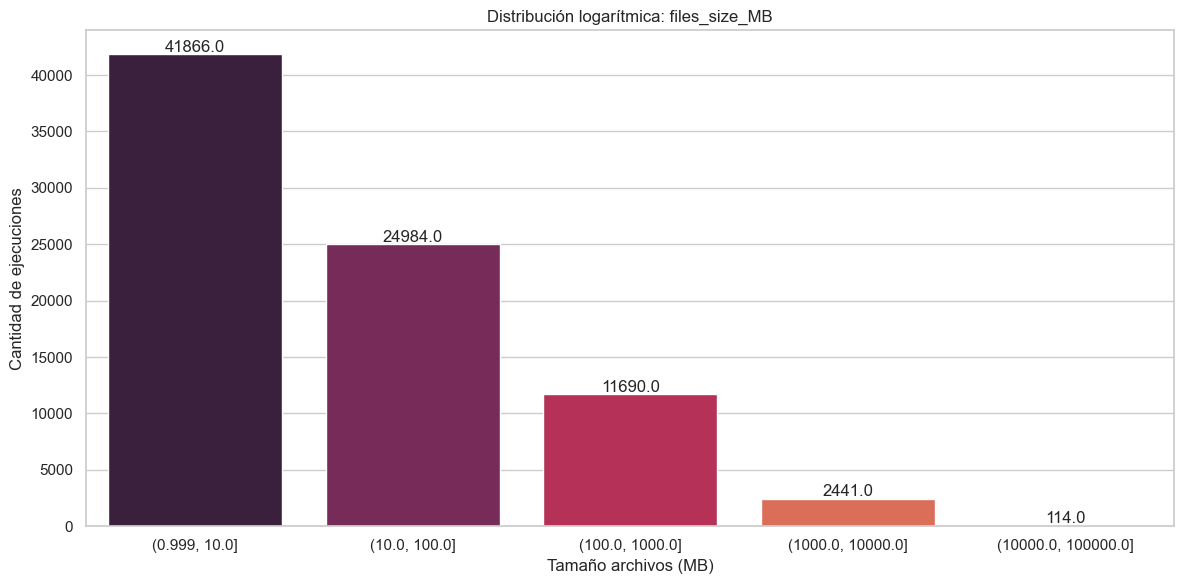

In [153]:
# Grafica de barras en escala logaritmica de tamaño (MB) de los archivos transmitidos
gf_barras_log(data, 'files_size_MB', 'Tamaño archivos (MB)', 'Cantidad de ejecuciones')

## 4. Agrupación datos por intervalo de tiempo
Para facilitar el analisis se realizará la agrupación por las transmisiones que hayan finalizado ("date_end_transmission") dentro del mismo intervalo de 5 minutos.
Para esto se requiere:
1. Ordenar los datos por la columna "date_end_transmission"
2. Agrupar por períodos de 5 minutos
3. Sumar la cantidad de ejecuciones OK/NOK/PEN durante ese intervalo (5 minutos)
4. Sumar la cantidad de archivos transmitidos en ese intervalo (5 minutos)
5. Sumar el tamaño de los archivos transmitidos en ese intervalo (5 minutos)
6. Sumar la cantidad de archivos transmitidos en modelo de "recoleccion" durante intervalos de 5 minutos
7. Sumar el tamaño de los archivos transmitidos en modelo "a demanda" durante intervalos de 5 minutos

### 4.1 Ordenar Dataframe por "date_end_transmission"

In [89]:
# 1. Setear el index y se orden
data_time = data.set_index('date_end_transmission').sort_index()
data_time.head(3)

,type_transmission,date_start_transmission,error_code,num_files,files_size_MB,duration_transmission
date_end_transmission,,,,,,
2025-04-07 00:00:01.463,recoleccion,2025-04-07 00:00:01.338,PEN,0,0.000000,0 days 00:00:00.125000
2025-04-07 00:00:12.535,a_demanda,2025-04-07 00:00:08.305,OK,1,0.010103,0 days 00:00:04.230000
2025-04-07 00:00:14.995,recoleccion,2025-04-07 00:00:12.393,PEN,0,0.000000,0 days 00:00:02.602000


### 4.2  Crear grupos por intervalos de 5 minutos

In [159]:
# 2. Crear grupos por intervalos tiemmpo
interval='5T' #se define intervalo de 5minutos
grouped = data_time.groupby(pd.Grouper(freq=interval))

### 4.3 Realizar operaciones sobre dataframe

In [160]:
# 3. Definir las operaciones sobre las columbas, desagregar columnas por subcategorias
agg_dict = {
    'error_code': [
        ('OK', lambda x: (x == 'OK').sum()),
        ('NOK', lambda x: (x == 'NOK').sum()),
        ('PEN', lambda x: (x == 'PEN').sum())
    ],
    'type_transmission': [
        ('a_demanda', lambda x: (x == 'a_demanda').sum()),
        ('recoleccion', lambda x: (x == 'recoleccion').sum())
    ],
    'num_files': [('total', 'sum')],
    'files_size_MB': [('total', 'sum')]
}

In [161]:
# 4. Aplicar las agregaciones
data_result = grouped.agg(agg_dict)

In [162]:
# 5. Aplanar el MultiIndex en columnas
data_result.columns = ['_'.join(col) for col in data_result.columns]

In [163]:
# 6. Rellenar intervalos faltantes
min_time = data_time.index.min().floor(interval)
max_time = data_time.index.max().ceil(interval)
full_range = pd.date_range(start=min_time, end=max_time, freq=interval)
data_result = data_result.reindex(full_range, fill_value=0)


In [165]:
data_result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10120 entries, 2025-04-07 00:00:00 to 2025-05-12 03:15:00
Freq: 5min
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   error_code_OK                  10120 non-null  int64  
 1   error_code_NOK                 10120 non-null  int64  
 2   error_code_PEN                 10120 non-null  int64  
 3   type_transmission_a_demanda    10120 non-null  int64  
 4   type_transmission_recoleccion  10120 non-null  int64  
 5   num_files_total                10120 non-null  int64  
 6   files_size_MB_total            10120 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 632.5 KB


In [164]:
data_result

,error_code_OK,error_code_NOK,error_code_PEN,type_transmission_a_demanda,type_transmission_recoleccion,num_files_total,files_size_MB_total
2025-04-07 00:00:00,5,1,33,1,38,55,62.717814
2025-04-07 00:05:00,5,0,7,2,10,5,289.799289
2025-04-07 00:10:00,5,0,8,1,12,5,307.609206
2025-04-07 00:15:00,2,0,11,0,13,19,155.886425
2025-04-07 00:20:00,3,1,12,0,16,3,1627.574952
...,...,...,...,...,...,...,...
2025-05-12 02:55:00,0,0,0,0,0,0,0.000000
2025-05-12 03:00:00,0,0,0,0,0,0,0.000000
2025-05-12 03:05:00,0,0,0,0,0,0,0.000000
2025-05-12 03:10:00,1,0,0,0,1,24974,9.696849


In [157]:
#Almacenar archivo depurado y organizado
data_result.to_csv('02_data_prepared.csv', index=True, header=True)

### Resumen de la sesión: Agrupación por intervalo de tiempo
En esta sesión se realizó la agrupación de los registros por ventanas de tiempo de 5 minutos, la intención de esto es agrupar toda la información obtenida de cada transferencia y agruparla por intervalos fijos. Esto hizo que se organizara los registros en base a su timestamp de finalizacion y se sumara sus datos (tamaños de archivos, cantidad de archivos, escenario de archivo) ejecutado durante dicho intervalo. el resultado es un nuevo dataframe del cual se almaceno su data en el archivo "02_data_prepared.csv".

Tambien es importante resaltar que se crearon las columnas en el nuevo dataframe: 

- error_code_OK: int64, indica la cantidad de transferencias ejecutadas con estado "OK" en el intervalo de tiempo
- error_code_NOK: int64, indica la cantidad de transferencias ejecutadas con estado "NOK" en el intervalo de tiempo
- error_code_PEN: int64, indica la cantidad de transferencias ejecutadas con estado "PEN" en el intervalo de tiempo
- type_transmission_a_demanda: int64, indica la cantidad de transferencias ejecutadas del modelo "a_demanda" en el intervalo de tiempo
- type_transmission_recoleccion: int64, indica la cantidad de transferencias ejecutadas del modelo "recoleccion" en el intervalo de tiempo
- num_files_total: int64, indica la cantidad de archivos transferidos en el intervalo de tiempo
- files_size_MB_total: float64, indica el tamaño de los archivos transferidos en el intervalo de tiempo

Se ignoraron las siguientes columnas del dataframe original:
- type_transmission: object, dado que se crearon 2 nuevas columnas de tipo numerica con la cantidad de transmisiones ejecutadas en el intervalo de tiempo por "type_transmission"
- date_start_transmission: datetime64, dado que solamente se concideró "date_end_transmission" como referencia de tiempo para el analisis del comportamiento de la data por que los registros iniciales son registrados solo cuando la transmision es finalizada, es decir, las transmisiones que no se pueden ejecutar (por indisponibilidad del sistema) NO aparecen registradas.
- error_code: object, dado que se crearon 3 nuevas columnas de tipo numerica con la cantidad de transmisiones ejecutadas en el intervalo de tiempo por "error_code"
- num_files: int64, dado que se creo una nueva columna de tipo numerica donde se registra el acumulado de cantidad de archivos transmitidos.
- files_size_MB: float64, dado que se creo una nueva columna de tipo numerica donde se registra el tamaño acumulado de archivos transmitidos.
- duration_transmission: timedelta64, esta información fue más a nivel de negocio que se generó pero no contribuye al analisis de la indisponibilidad de la herramienta, dado que lo que interesa es la cantidad de ejecuciones y no la duracion de las transmisiones.

Se conservaron/transformaron las siguientes columnas del dataframe original:
- date_end_transmission: datetime64, se ordenaron los registros del dataframe de forma ascendente en la linea de tiempo y se asigno como indice al dataframe nuevo


## 6. Visualizaciones de datos por ventanas de tiempo

### 6.1 Estado de transmisiones por dia de semana 

In [104]:
# Extraer el día de la semana del índice DateTime (0=lunes, 6=domingo)
data_result['dia_semana'] = data_result.index.dayofweek

# Agrupar por día de la semana y calcular la suma de cada código de error
error_por_dia_semana = data_result.groupby('dia_semana')[['error_code_OK', 'error_code_NOK', 'error_code_PEN']].sum()

# Mapear números de día a nombres
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
error_por_dia_semana.index = dias

# Calcular totales y porcentajes
total_por_dia = error_por_dia_semana.sum(axis=1)
porcentajes = error_por_dia_semana.div(total_por_dia, axis=0) * 100

<Figure size 1200x600 with 0 Axes>

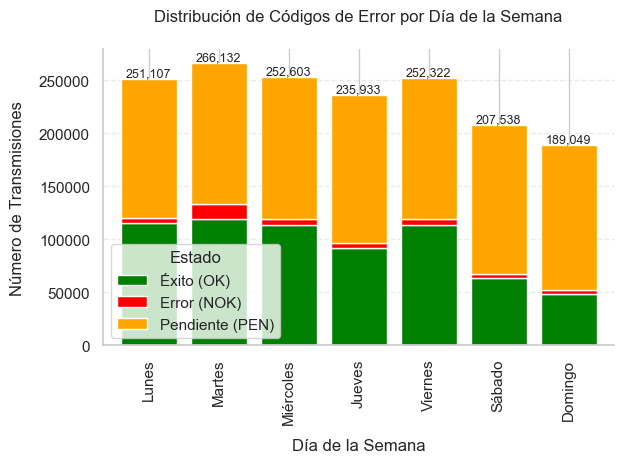

In [106]:
plt.figure(figsize=(12, 6))
ax = error_por_dia_semana.plot(kind='bar', stacked=True, color=['green', 'red', 'orange'], width=0.8)

plt.title('Distribución de Códigos de Error por Día de la Semana', pad=20)
plt.xlabel('Día de la Semana', labelpad=10)
plt.ylabel('Número de Transmisiones', labelpad=10)
plt.legend(['Éxito (OK)', 'Error (NOK)', 'Pendiente (PEN)'], title='Estado')

# Añadir etiquetas con el total por día
for i, total in enumerate(total_por_dia):
    ax.text(i, total, f'{total:,}', ha='center', va='bottom', fontsize=9)

# Personalizar ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

###  6.2 Gráfico de Transmisiones Totales por Hora

In [110]:
# Extraer la hora del índice temporal
data_result['hora'] = data_result.index.hour

# Calcular total de transmisiones por intervalo
data_result['total_transmisiones'] = data_result['error_code_OK'] + data_result['error_code_NOK'] + data_result['error_code_PEN']

# Agrupar por hora y calcular estadísticas
transmisiones_por_hora = data_result.groupby('hora')['total_transmisiones'].agg(['sum', 'mean', 'count'])

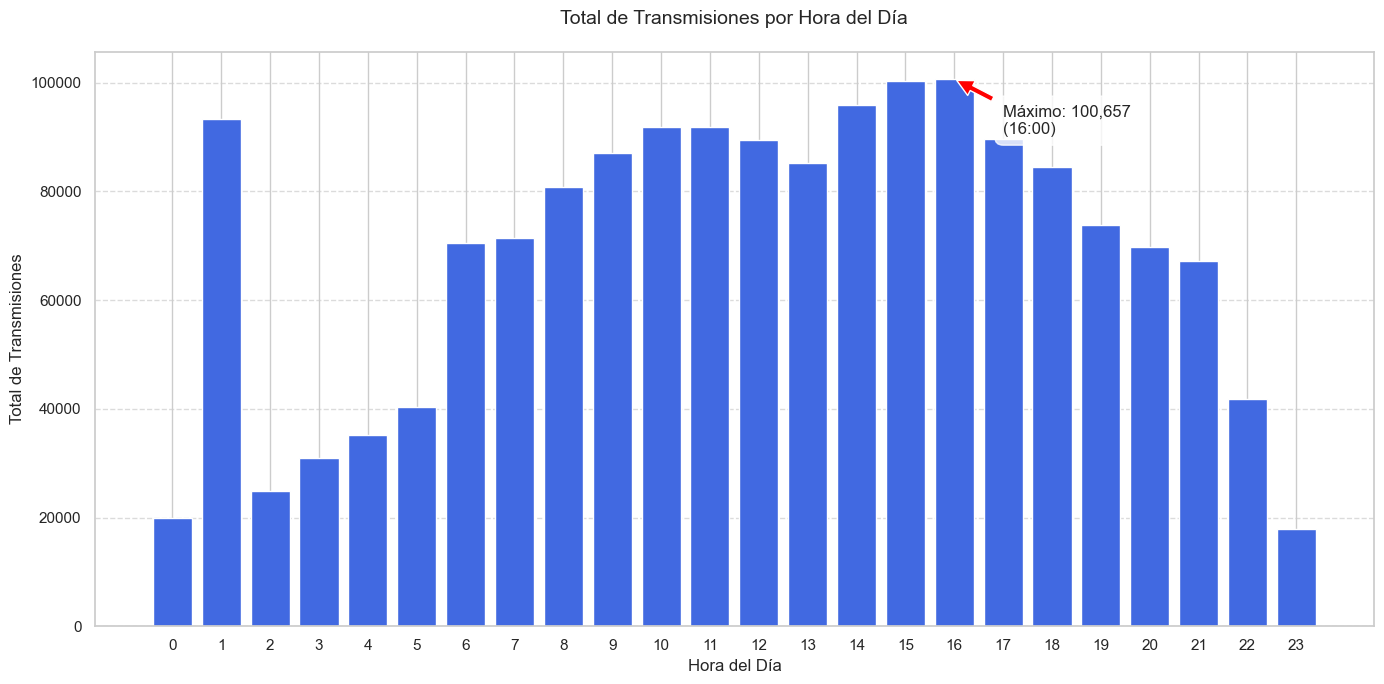

In [111]:
plt.figure(figsize=(14, 7))
plt.bar(transmisiones_por_hora.index, transmisiones_por_hora['sum'], color='royalblue')

plt.title('Total de Transmisiones por Hora del Día', pad=20, fontsize=14)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Total de Transmisiones', fontsize=12)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Destacar las horas pico
max_hora = transmisiones_por_hora['sum'].idxmax()
max_valor = transmisiones_por_hora['sum'].max()
plt.annotate(f'Máximo: {max_valor:,}\n({max_hora}:00)', 
             xy=(max_hora, max_valor), 
             xytext=(max_hora+1, max_valor*0.9),
             arrowprops=dict(facecolor='red', shrink=0.05),
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

###  6.3 Gráfico de Transmisiones Promedio por Hora

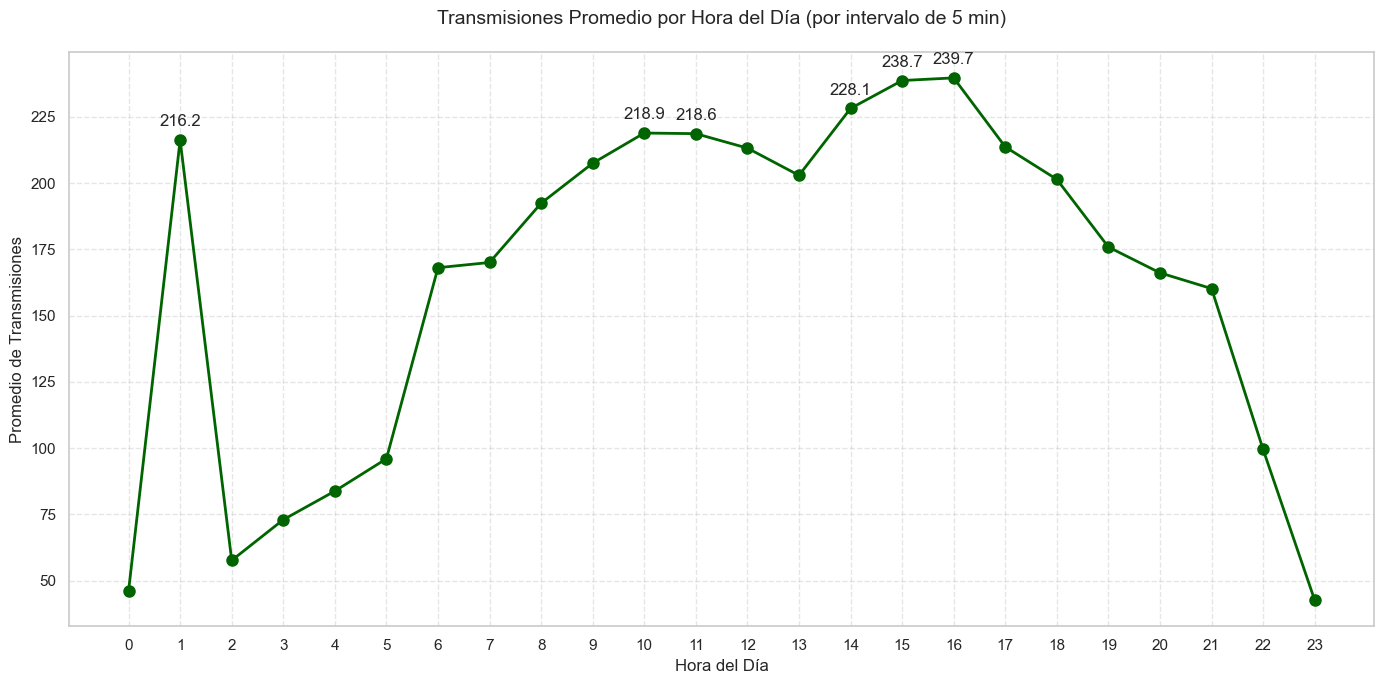

In [113]:
plt.figure(figsize=(14, 7))
plt.plot(transmisiones_por_hora.index, transmisiones_por_hora['mean'], 
         marker='o', color='darkgreen', linewidth=2, markersize=8)

plt.title('Transmisiones Promedio por Hora del Día (por intervalo de 5 min)', pad=20, fontsize=14)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Promedio de Transmisiones', fontsize=12)
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.5)

# Marcar horas importantes
for hora in transmisiones_por_hora.index:
    if transmisiones_por_hora['mean'][hora] > transmisiones_por_hora['mean'].quantile(0.75):
        plt.annotate(f'{transmisiones_por_hora["mean"][hora]:.1f}', 
                    (hora, transmisiones_por_hora["mean"][hora]),
                    textcoords="offset points", 
                    xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

###  6.4 Gráfico de Calor por Hora y Día de la Semana

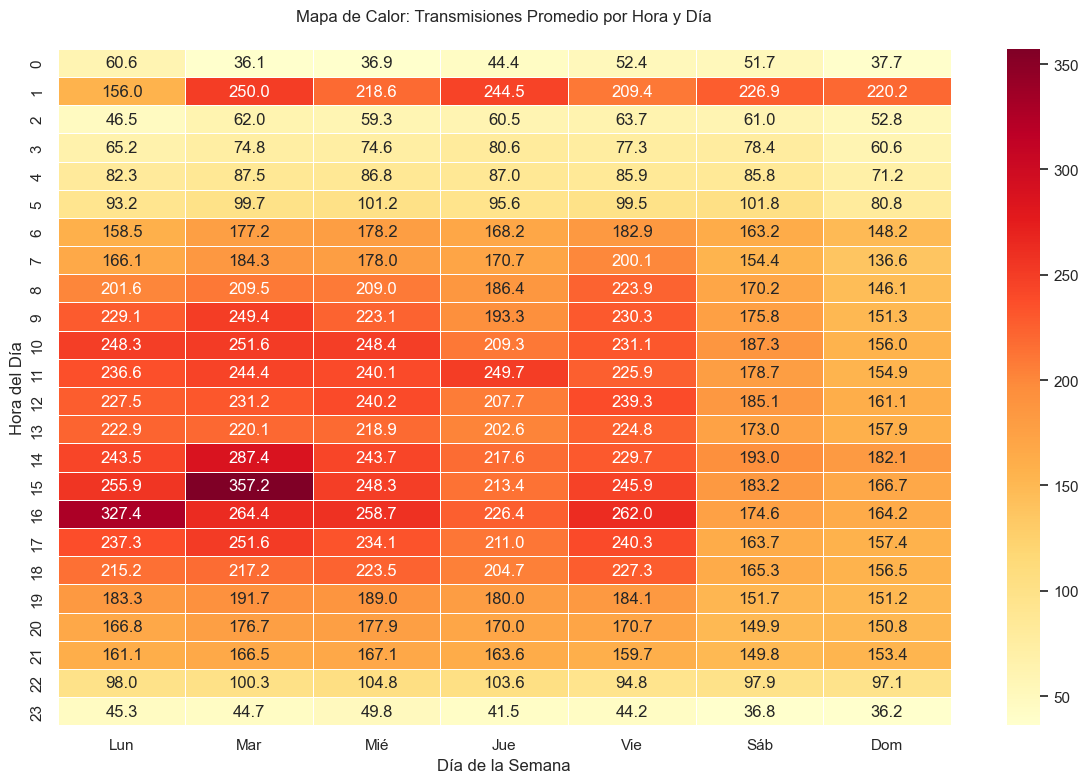

In [114]:
# Crear matriz de horas vs días de semana
transmisiones_hora_dia = data_result.pivot_table(
    index='hora',
    columns='dia_semana',
    values='total_transmisiones',
    aggfunc='mean'
)

# Mapear números de día a nombres
dias_semana = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
transmisiones_hora_dia.columns = dias_semana

plt.figure(figsize=(12, 8))
sns.heatmap(transmisiones_hora_dia, cmap='YlOrRd', annot=True, fmt='.1f', linewidths=.5)
plt.title('Mapa de Calor: Transmisiones Promedio por Hora y Día', pad=20)
plt.xlabel('Día de la Semana')
plt.ylabel('Hora del Día')
plt.tight_layout()
plt.show()

###  6.5 Gráfico Combinado (Promedio + Percentiles)

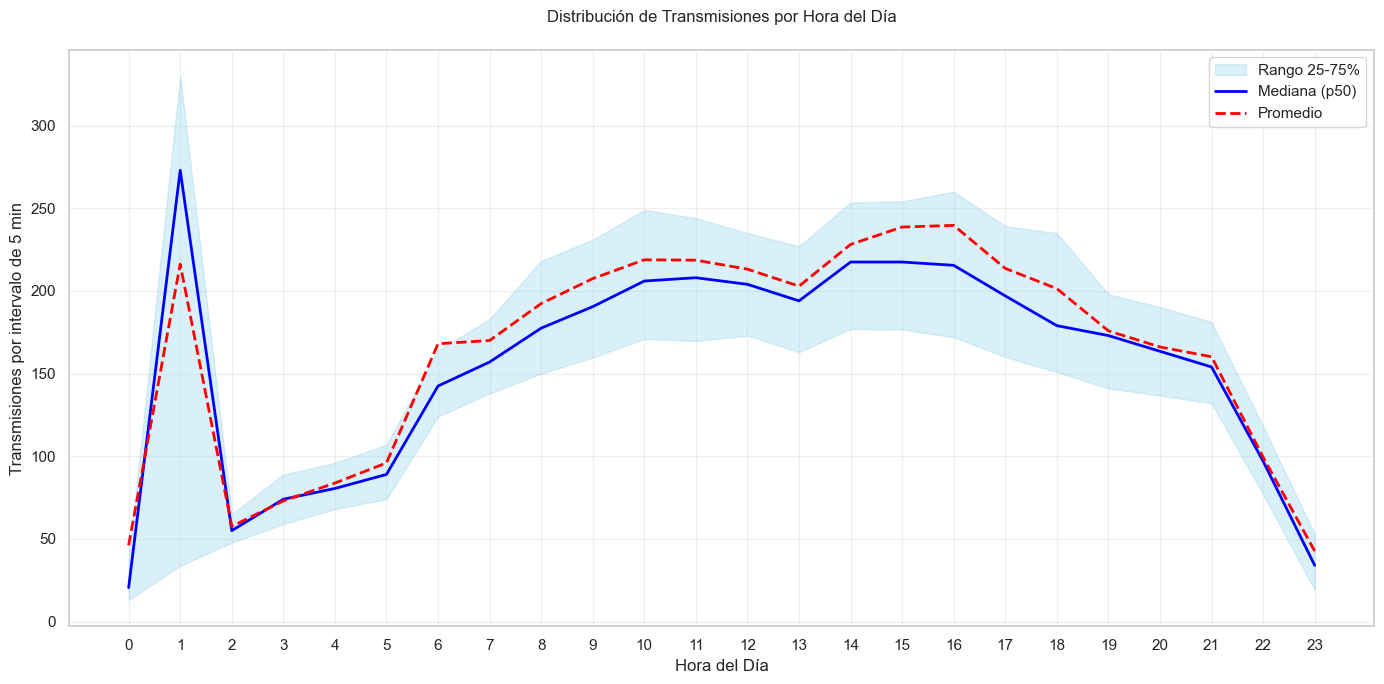

In [116]:
# Calcular percentiles por hora
percentiles = data_result.groupby('hora')['total_transmisiones'].agg(
    p25=lambda x: x.quantile(0.25),
    p50=lambda x: x.quantile(0.5),
    p75=lambda x: x.quantile(0.75)
)

plt.figure(figsize=(14, 7))
plt.fill_between(percentiles.index, percentiles['p25'], percentiles['p75'], 
                 color='skyblue', alpha=0.3, label='Rango 25-75%')
plt.plot(percentiles.index, percentiles['p50'], 
         color='blue', linewidth=2, label='Mediana (p50)')
plt.plot(transmisiones_por_hora.index, transmisiones_por_hora['mean'], 
         color='red', linestyle='--', linewidth=2, label='Promedio')

plt.title('Distribución de Transmisiones por Hora del Día', pad=20)
plt.xlabel('Hora del Día')
plt.ylabel('Transmisiones por intervalo de 5 min')
plt.xticks(range(24))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

###  6.6 Resumen Numerico

In [169]:
#Semanas
print("\n--- Estadísticas por Día de la Semana ---")
# Cuenta días con al menos un registro
print(f"Total Días con registros: {data_result.resample('D').size().astype(bool).sum()}")
print(f"Total de transmisiones analizadas: {error_por_dia_semana.sum().sum():,}")


print("\nDías con:")
print(f"Mayor éxito: {error_por_dia_semana['error_code_OK'].idxmax()} ({error_por_dia_semana['error_code_OK'].max():,})")
print(f"Mayor error: {error_por_dia_semana['error_code_NOK'].idxmax()} ({error_por_dia_semana['error_code_NOK'].max():,})")
print(f"Mayor pendientes: {error_por_dia_semana['error_code_PEN'].idxmax()} ({error_por_dia_semana['error_code_PEN'].max():,})")

print("\nTasa promedio de éxito:", f"{porcentajes['error_code_OK'].mean():.1f}%")
print("Tasa promedio de error:", f"{porcentajes['error_code_NOK'].mean():.1f}%")
print("Tasa promedio de pendientes:", f"{porcentajes['error_code_PEN'].mean():.1f}%")

#Horas
print("\n--- Estadísticas por Hora del Día ---")
print(f"Hora con mayor volumen total: {transmisiones_por_hora['sum'].idxmax()}:00")
print(f"Hora con mayor promedio: {transmisiones_por_hora['mean'].idxmax()}:00")
print("\nTop 5 horas con más transmisiones:")
print(transmisiones_por_hora['sum'].sort_values(ascending=False).head(5))
print("\nTop 5 horas con menos transmisiones:")
print(transmisiones_por_hora['sum'].sort_values().head(5))

# Calcular diferencia entre hora pico y valle
diferencia = transmisiones_por_hora['sum'].max() / transmisiones_por_hora['sum'].min()
print(f"\nDiferencia entre hora pico y valle: {diferencia:.1f} veces")


--- Estadísticas por Día de la Semana ---
Total Días con registros: 36
Total de transmisiones analizadas: 1,654,684

Días con:
Mayor éxito: Martes (119,410)
Mayor error: Martes (14,285)
Mayor pendientes: Sábado (140,481)

Tasa promedio de éxito: 39.4%
Tasa promedio de error: 2.5%
Tasa promedio de pendientes: 58.1%

--- Estadísticas por Hora del Día ---
Hora con mayor volumen total: 16:00
Hora con mayor promedio: 16:00

Top 5 horas con más transmisiones:
hora
16    100657
15    100240
14     95817
1      93404
10     91919
Name: sum, dtype: int64

Top 5 horas con menos transmisiones:
hora
23    17909
0     19915
2     24895
3     30948
4     35188
Name: sum, dtype: int64

Diferencia entre hora pico y valle: 5.6 veces


###  6.7 Resumen de la sesión: Visualizacion data

- Los datos dan una vision general del comportamiento de la herramienta MFT transaccional, donde se identifica las horas del dia con mayor transaccionalidad (16,15,14,1 y 10 horas respectivamente) y los dias con más trafico (martes)
- Tambien es importante tener en cuenta el grafico de percentiles por que da un intervalo de ejecuciones por dia/hora, y este intervalo de "tolerancia" es necesario para no generar falsos alertamientos en caso de que la cantidad de transaccion de un dia este bajo.
- Es importante seguir registrando más dias de datos, dado que solo se incluye un dia 15, un dia 30 y un 1 de mes, dias en donde la transaccionalidad es más critica
